# Localisation et détection d'objet

Dans ce TP, nous allons mettre en pratique certaines des méthodes présentées en cours pour localiser des objets dans une image.

En localisation et détection, on cherche à déterminer la position d'un objet, ainsi que sa classe, sous la forme d'une boîte englobante de largeur $b_w$ et hauteur $b_h$, et dont le centre a pour coordonnées le point $(b_x, b_y)$. 

<center> <img src="https://drive.google.com/uc?id=1_jHHv6ZDe-3Xz25jIZ6o177laBEfmMRR" style="width:500;height:300px;"></center>
<caption><center> Figure 1: Modèle de boîte englobante utilisé pour la localisation </center></caption>

Le problème de localisation considère qu'un seul objet est présent sur l'image, alors que le problème de détection cherche à déterminer l'ensemble des objets présents sur l'image.



Pour commencer, récupérez les images de la base de données :


In [1]:
!git clone https://github.com/axelcarlier/mangeoires_loc.git

Cloning into 'mangeoires_loc'...
remote: Enumerating objects: 2333, done.
remote: Total 2333 (delta 0), reused 0 (delta 0), pack-reused 2333
Receiving objects: 100% (2333/2333), 48.39 MiB | 20.58 MiB/s, done.


La base de données consiste en des photographies prises par une caméra reliée à une Raspberry Pi, cachée dans une mangeoire. Plusieurs mangeoires sont disséminées dans la nature en Occitanie, et l'objectif de [ce projet](https://econect.cnrs.fr/) est la reconnaissance des espèces et le comptage des individus qui viennent se poser devant le caméra, afin de suivre l'évolution des populations d'oiseaux et ainsi monitorer la biodiversité.

La base de données qui vous est fournie regroupe 11 espèces d'animaux, majoritairement des oiseaux, désignés par un code : 

1. Mésange charbonnière (**MESCHA**)
2. Verdier d'Europe (**VEREUR**)
3. Écureuil roux (**ECUROU**)
4. Pie bavarde (**PIEBAV**)
5. Sittelle torchepot (**SITTOR**)
6. Pinson des arbres (**PINARB**)
7. Mésange noire (**MESNOI**)
8. Mésange nonnette (**MESNON**)
9. Mésange bleue (**MESBLE**)
10. Rouge-gorge (**ROUGOR**)
11. Accenteur mouchet (**ACCMOU**)



<center> <img src="https://drive.google.com/uc?id=1Eit86N4D0Ea7ai1rBa0o-GmTwckhP9i0" width=200>
<img src="https://drive.google.com/uc?id=1lC7WL93UqDT_KV2m21yx99N5dkf98nCY" width=200>
<img src="https://drive.google.com/uc?id=10tzJORcSrSckDWmBDBtc8FUirxdbRxri" width=200>
<img src="https://drive.google.com/uc?id=1IHZp_B6bc8bADtAReRHhcyOjDQZAXDBQ" width=200></center>
<caption><center> Figure 2: Exemples d'images de la base de données </center></caption>

# Localisation et classification d'objet

Dans cette partie, nous allons nous concentrer sur le problème de la localisation d'un seul objet par classe. La base de données a été épurée pour se concentrer uniquement sur ce cas.


In [2]:
import PIL
from PIL import Image
import csv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


## Préparation des données

Le code ci-dessous permet de charger les données et les formater pour la classification. Prenez le temps de regarder un peu le format des labels $y$.
Notez que les images sont rendues carrées lors du chargement.

In [3]:
# Lecture du CSV contenant les informations relatives à la base de données
dataset = []
with open('mangeoires_loc/bd_mangeoires_equilibre.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
	for row in filereader:
		data = row[0].split(',')
		if data[0] != 'Data':
			box = [float(data[5]), float(data[6]), float(data[7]), float(data[8])]
			new_entry = {'type': data[0], 'specie': data[1], 'path': data[2], 'shape': [float(data[3]), float(data[4])], 'box': box}
			dataset.append(new_entry)

# Nombre de classes de la base de données et intitulé des classes
class_labels = list(dict.fromkeys([item['specie'] for item in dataset]))
num_classes = len(class_labels)

# Extraction des données d'apprentissage et de test   
dataset_train = [item for item in dataset if item['type']=='TRAIN']
dataset_test = [item for item in dataset if item['type']=='TEST']

print(class_labels)

['MESCHA', 'VEREUR', 'ECUROU', 'PIEBAV', 'SITTOR', 'PINARB', 'MESNOI', 'MESNON', 'MESBLE', 'ROUGOR', 'ACCMOU']


In [4]:
def build_localization_tensors(image_size, dataset, num_classes):
  # Préparation des structures de données pour x et y
  x = np.zeros((len(dataset), image_size, image_size, 3))
  y = np.empty((len(dataset), num_classes + 5)) # 1 + 4 + num_classes : présence / boîte englobante / classes

  # Compteur de parcours du dataset
  i = 0

  for item in dataset:
    # Lecture de l'image
    img = Image.open('mangeoires_loc/' + item['path'])
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.ANTIALIAS)
    # Remplissage de la variable x
    x[i] = np.asarray(img)

    y[i, 0] = 1 # Un objet est toujours présent !

    # Coordonnées de boîte englobante
    img_shape = item['shape']
    box = item['box']
    bx = (box[0] + (box[2] - box[0])/2)/img_shape[0]
    by = (box[1] + (box[3] - box[1])/2)/img_shape[1]
    bw = (box[2] - box[0])/img_shape[0]
    bh = (box[3] - box[1])/img_shape[1]
    y[i, 1] = bx
    y[i, 2] = by
    y[i, 3] = bw
    y[i, 4] = bh

    # Probabilités de classe, sous la forme d'une one-hot vector
    label = class_labels.index(item['specie'])
    classes_probabilities = keras.utils.to_categorical(label, num_classes=num_classes)
    y[i, 5:] = classes_probabilities

    i = i+1

  return x, y


Séparation des données d'entraînement pour extraire un ensemble de validation, et pré-traitement des données.

In [5]:
from sklearn.model_selection import train_test_split


# Pour la suite du TP on considèrera des images de taille 64x64x3
# Augmenter cette valeur donnerait de meilleurs résultats mais nécessiterait des calculs plus long.
IMAGE_SIZE = 64

# Lecture des données d'entraînement et de test
x, y = build_localization_tensors(IMAGE_SIZE, dataset_train, num_classes)
x_test, y_test = build_localization_tensors(IMAGE_SIZE, dataset_test, num_classes)

#Extraction d'un ensemble de validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)

# Pour améliorer l'entraînement, on peut centrer-réduire les coordonnées des bounding boxes...
y_std = np.std(y_train, axis=0)
y_mean = np.mean(y_train, axis=0)
y_train[...,1:5] = (y_train[...,1:5] - y_mean[1:5])/y_std[1:5]
y_val[...,1:5] = (y_val[...,1:5] - y_mean[1:5])/y_std[1:5]
y_test[...,1:5] = (y_test[...,1:5] - y_mean[1:5])/y_std[1:5]

# ... et normaliser les valeurs de couleur
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

## Fonctions utiles

Une fonction de calcul de l'intersection sur union, qui nous sera utile pour les métriques d'évaluation de nos méthodes :

$$ IoU (R_1, R_2) = \frac{\mathcal{A} (R_1 \cap R_2)}{\mathcal{A} (R_1 \cup R_2)} = \frac{\mathcal{A} (R_1 \cap R_2)}{\mathcal{A} (R_1) + \mathcal{A} (R_2) -  \mathcal{A} (R_1 \cap R_2)} $$ 

<center>
<img src="https://drive.google.com/uc?id=1BQx2kDOCltZ_5gcnKVWTVUVNmGk-7qBC" width=500>
</center>


In [30]:
### A COMPLETER
def intersection_sur_union(box1, box2):
  """
  Calcul de l'intersection sur union entre deux rectangles box1 et box2

  Arguments:
  box1, box2 -- les coordonnées des deux rectangles, chacun sous la forme [cx, cy, w, h]
                où (cx, cy) désigne les coordonnées du centre du rectangle, 
                w sa largeur et h sa hauteur

  Retourne :
  iou -- la valeur d'intersection sur union entre les deux rectangles 
  """
  x11 = box1[0] - box1[2]/2
  y11 = box1[1] - box1[3]/2
  x12 = box1[0] + box1[2]/2
  y12 = box1[1] + box1[3]/2

  x21 = box2[0] - box2[2]/2
  y21 = box2[1] - box2[3]/2
  x22 = box2[0] + box2[2]/2
  y22 = box2[1] + box2[3]/2

  # Calcul des coordonnées des coins du rectangle d'intersection
  xI1 = max(x11, x21)
  yI1 = max(y11, y21)
  xI2 = min(x12, x22)
  yI2 = min(y12, y22)

  # Calcul de l'aire du rectangle d'intersection
  inter = (xI2 - xI1) * (yI2 - yI1)

  # Calcul de l'aire des deux rectangles
  area1 = (x12 - x11) * (y12 - y11)
  area2 = (x22 - x21) * (y22 - y21)

  # Calcul de l'intersection sur union
  iou = inter / (area1 + area2 - inter)

  return iou

In [31]:
print(intersection_sur_union([2.5, 2, 1, 4], [2, 3, 4, 2]))  # Résultat attendu : 0.2
print(intersection_sur_union([2.5, 2, 1, 4], [5, 3, 4, 2]))  # Résultat attendu : 0.0

0.2
0.0


Calcul des différentes métriques : 

$$ P = \frac{TP}{TP + FP} $$

$$ R = \frac{TP}{TP + FN} $$

$$ F1 = \frac{2}{\frac{1}{P} + \frac{1}{R}} $$

où $TP$ désigne le nombre de vrais positifs, $FP$ le nombre de faux positifs, $FN$ le nombre de faux négatifs, $P$ la précision, $R$ le rappel et $F1$ le F1-score.

On considère souvent qu'une détection est correcte si la classification est valide et que l'intersection sur union entre vérité terrain et prédiction est supérieure à 0.5 (on utilisera un seuil modifiable *iou_thres*).

In [70]:
# A COMPLETER
def global_accuracy(y_true, y_pred, iou_thres=0.5):
  """
  Calcul, pour chaque classe de la précision, du rappel et du F1-score ainsi 
  que du pourcentage global de bonnes détections.

  Arguments:
  y_true -- les labels de la vérité terrain, de dimension (M, 1+4+N) où M désigne
          le nombre d'éléments du dataset et N le nombre de classes (11 dans notre cas)
  y_pred -- les labels prédits par un modèle, de dimension (M, 1+4+N)  
  iou_thres -- seuil d'intersection sur union entre une boîte "vérité-terrain" et 
              une boite prédite au-dessus duquel on considère que la prédiction est correcte          

  Retourne :
  class_res -- liste de longueur N contenant des dictionnaires sous la forme 
            {"Précision": p, "Rappel": r, "F-score": f} résumant les métriques
            précision, rappel et F1-score pour chacune des classes.
  accuracy -- pourcentage global de bonnes détections
  """
  # Initialisation des métriques : nombre de vrais positifs (TP), faux positifs (FP)
  # et faux négatifs (FN) pour chaque classe
  class_metrics = []
  for i in range(num_classes):
    class_metrics.append({'TP': 0, 'FP': 0, 'FN': 0})

  # Nombres de détections correctes et de détections incorrectes
  total_correct_detections = 0
  total_incorrect_detections = 0
  for i in range(y_true.shape[0]):
    # Labels vérité-terrain et prédits
    groundtruth_label = np.argmax(y_true[i,5:])
    predicted_label = np.argmax(y_pred[i,5:])

    # Coordonnées de boîtes englobantes réelles et prédites
    bx_true = (y_true[i,1]*y_std[1] + y_mean[1])
    by_true = (y_true[i,2]*y_std[2] + y_mean[2])
    bw_true = (y_true[i,3]*y_std[3] + y_mean[3])
    bh_true = (y_true[i,4]*y_std[4] + y_mean[4])  
    bx_pred = (y_pred[i,1]*y_std[1] + y_mean[1])
    by_pred = (y_pred[i,2]*y_std[2] + y_mean[2])
    bw_pred = (y_pred[i,3]*y_std[3] + y_mean[3])
    bh_pred = (y_pred[i,4]*y_std[4] + y_mean[4])  

    # Calcul de l'intersection sur union
    iou = intersection_sur_union([bx_true, by_true, bw_true, bh_true], [bx_pred, by_pred, bw_pred, bh_pred])
    
    ### A COMPLETER
    # Si la détection est correcte : 
    if groundtruth_label == predicted_label and iou > iou_thres:
      # On incrémente le nombre de détections correctes
      total_correct_detections += 1
      # On incrémente le nombre de vrais positifs pour la classe prédite
      class_metrics[predicted_label]['TP'] += 1
    else:
      # Sinon on incrémente le nombre de détections incorrectes
      total_incorrect_detections += 1
      # On incrémente le nombre de faux positifs pour la classe prédite
      class_metrics[predicted_label]['FP'] += 1
      # On incrémente le nombre de faux négatifs pour la classe réelle
      class_metrics[groundtruth_label]['FN'] += 1

  class_res = []
  for i in range(num_classes):
    TP = class_metrics[i]['TP']
    FP = class_metrics[i]['FP']
    FN = class_metrics[i]['FN']
    if TP == 0:
      P = 0
      R = 0
      F_score = 0
    else:
      P = TP/(TP+FP)
      R = TP/(TP+FN)
      F_score = 2*P*R/(P+R)
    class_res.append({'Precision': P, 'Rappel': R, 'F-score': F_score})

  accuracy = 100 * total_correct_detections / (total_correct_detections + total_incorrect_detections) 

  ### FIN
  return class_res, accuracy

In [71]:
num_class_test = 3
class_labels_test = ['Classe 1', 'Classe 2', 'Classe 3']
y_true_test = np.ones((num_class_test,8))
y_true_test[0,:2] = [0.5, 0.5]
y_true_test[0, 5:] = [1, 0, 0]
y_true_test[1,:2] = [0.5, 0.5]
y_true_test[1, 5:] = [0, 1, 0]
y_true_test[2,:2] = [0.5, 0.5]
y_true_test[2, 5:] = [0, 0, 1]
y_pred_test = np.ones((num_class_test,8))
y_pred_test[0,:2] = [0.6, 0.6]
y_pred_test[0, 5:] = [1, 0, 0]
y_pred_test[1,:2] = [2.5, 2.5]
y_pred_test[1, 5:] = [0, 0, 1]
y_pred_test[2,:2] = [0.6, 0.6]
y_pred_test[2, 5:] = [0, 0, 1]

class_res_test, acc_test = global_accuracy(y_true_test, y_pred_test)

print(f"La précision globale est de {acc_test:.1f}%")

print()
print("--------------------------------------------")
print("|  Classe  | Précision | Rappel | F1-score |")
print("--------------------------------------------")
for i in range(num_class_test):
  print(f"| {class_labels_test[i]:9s}|   {class_res_test[i]['Precision']:.2f}    |  {class_res_test[i]['Rappel']:.2f}  |   {class_res_test[i]['F-score']:.2f}   |")
  print("--------------------------------------------")

La précision globale est de 66.7%

--------------------------------------------
|  Classe  | Précision | Rappel | F1-score |
--------------------------------------------
| Classe 1 |   1.00    |  1.00  |   1.00   |
--------------------------------------------
| Classe 2 |   0.00    |  0.00  |   0.00   |
--------------------------------------------
| Classe 3 |   0.50    |  1.00  |   0.67   |
--------------------------------------------


**Affichage attendu :**
```
La précision globale est de 66.7%

--------------------------------------------
|  Classe  | Précision | Rappel | F1-score |
--------------------------------------------
| Classe 1 |   1.00    |  1.00  |   1.00   |
--------------------------------------------
| Classe 2 |   0.00    |  0.00  |   0.00   |
--------------------------------------------
| Classe 3 |   0.50    |  1.00  |   0.67   |
--------------------------------------------
```

La fonction ci-dessous permet de calculer l'intersection sur union  sur des tenseurs (et non des tableaux numpy), elle sera donc utilisable comme métrique pendant l'entraînement.

In [72]:
def compute_iou(y_true, y_pred):
  ### "Dénormalisation" des coordonnées des boîtes englobantes
  pred_box_xy = y_pred[..., 0:2]* y_std[0:2] + y_mean[0:2]
  true_box_xy = y_true[..., 0:2]* y_std[0:2] + y_mean[0:2]

  ### "Dénormalisation" des largeur et hauteur des boîtes englobantes
  pred_box_wh = y_pred[..., 2:4] * y_std[2:4] + y_mean[2:4]
  true_box_wh = y_true[..., 2:4] * y_std[2:4] + y_mean[2:4]
    
  # Calcul des coordonnées minimales et maximales des boiptes englobantes réelles
  true_wh_half = true_box_wh / 2.
  true_mins    = true_box_xy - true_wh_half
  true_maxes   = true_box_xy + true_wh_half
  
  # Calcul des coordonnées minimales et maximales des boiptes englobantes prédites
  pred_wh_half = pred_box_wh / 2.
  pred_mins    = pred_box_xy - pred_wh_half
  pred_maxes   = pred_box_xy + pred_wh_half       
  
  # Détermination de l'intersection des boîtes englobantes
  intersect_mins  = tf.maximum(pred_mins,  true_mins)
  intersect_maxes = tf.minimum(pred_maxes, true_maxes)
  intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
  
  # Aire des boîtes englobantes prédites et réelles
  true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
  pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

  # Aire de l'union des boîtes prédites et réelles
  union_areas = pred_areas + true_areas - intersect_areas

  iou_scores  = tf.truediv(intersect_areas, union_areas)
  return iou_scores

def iou():
  def iou_metrics(y_true, y_pred):
    return compute_iou(y_true, y_pred)
  iou_metrics.__name__= "IoU"
  return iou_metrics

Visualisation des données et labels

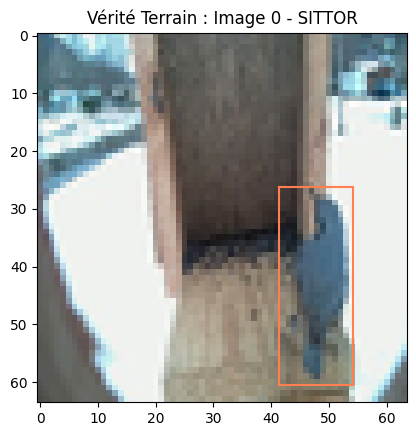

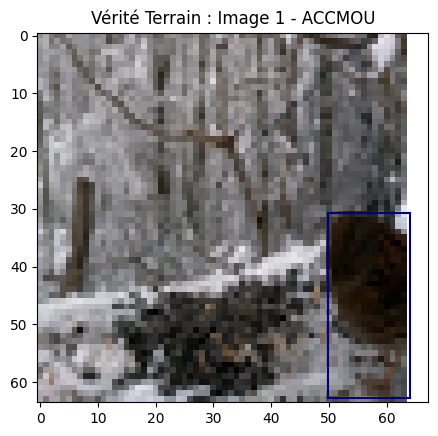

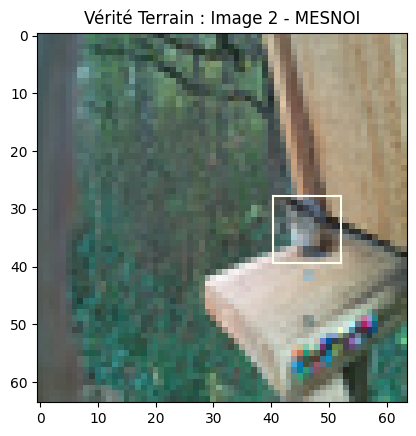

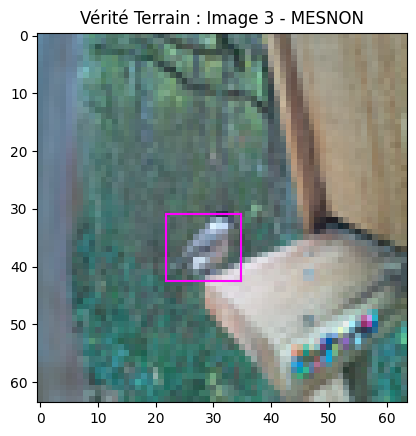

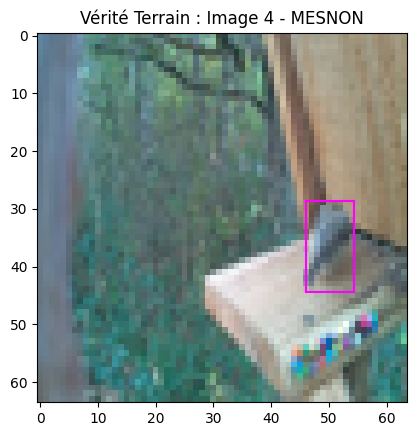

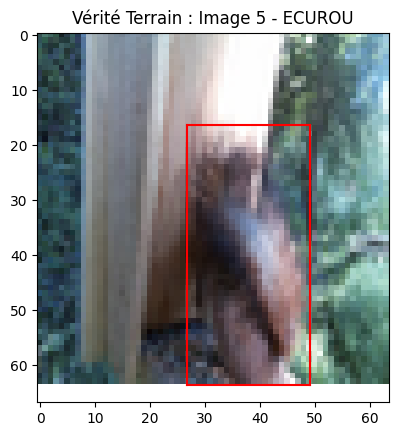

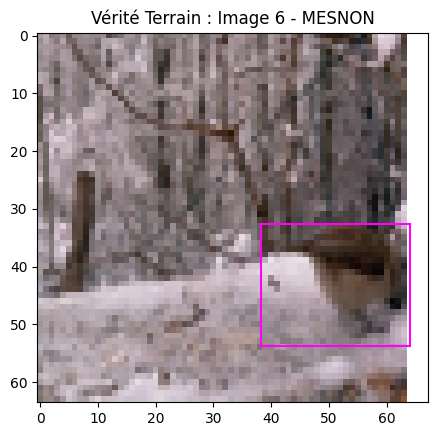

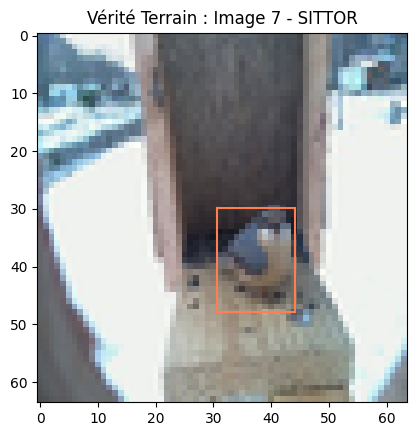

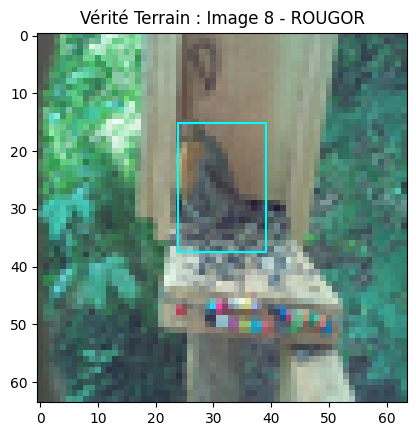

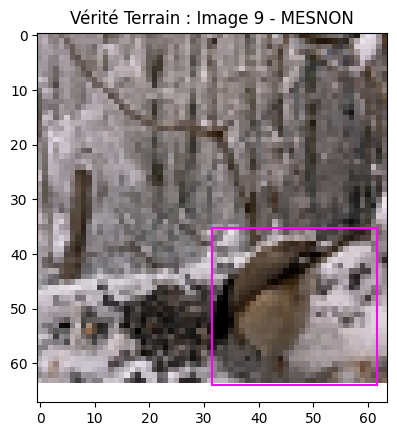

In [73]:
# Si seuls x et y sont indiqués, on tire au hasard un numéro d'image et on affiche le label y associé  à l'image
# Si un 2e y, nommé y_pred, est indiqué, alors les deux labels sont affichés côte à côte, afin de pouvoir les comparer
# Enfin on peut également indiquer l'id de l'image que l'on souhaite visualiser.
def print_data_localisation(x, y, y_pred=[], id=None, image_size=64):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id

  img = x[num_img]
  lab = y[num_img]

  colors = ["blue", "yellow", "red", "orange", "coral", "gold", "ivory", "fuchsia", "purple", "cyan", "navy"] # Différentes couleurs pour les différentes classes
  classes = ['MESCHA', 'VEREUR', 'ECUROU', 'PIEBAV', 'SITTOR', 'PINARB', 'MESNOI', 'MESNON', 'MESBLE', 'ROUGOR', 'ACCMOU']

  if np.any(y_pred):
    plt.subplot(1, 2, 1)

  # Affichage de l'image
  plt.imshow(img)
  # Détermination de la classe
  class_id = np.argmax(lab[5:])

  # Détermination des coordonnées de la boîte englobante dans le repère image
  ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
  ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
  width = (lab[3]*y_std[3] + y_mean[3]) * image_size
  height = (lab[4]*y_std[4] + y_mean[4]) * image_size
  #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
  # Détermination des extrema de la boîte englobante
  p_x = [ax-width/2, ax+width/2]
  p_y = [ay-height/2, ay+height/2]
  # Affichage de la boîte englobante, dans la bonne couleur
  plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
  plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
  plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
  plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
  plt.title("Vérité Terrain : Image {} - {}".format(num_img, classes[class_id]))

  if np.any(y_pred):
    plt.subplot(1, 2, 2)
    # Affichage de l'image
    plt.imshow(img)
    lab = y_pred[num_img]
    # Détermination de la classe
    class_id = np.argmax(lab[5:])

    # Détermination des coordonnées de la boîte englobante dans le repère image
    ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
    ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
    width = (lab[3]*y_std[3] + y_mean[3]) * image_size
    height = (lab[4]*y_std[4] + y_mean[4]) * image_size
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [ax-width/2, ax+width/2]
    p_y = [ay-height/2, ay+height/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Prédiction : Image {} - {}".format(num_img, classes[class_id]))

  plt.show()

for i in range(10):#x.shape[0]):
    print_data_localisation(x_train, y_train, image_size=IMAGE_SIZE, id=i)


Fonction d'affichage des courbes d'apprentissage et de validation

In [74]:
def plot_training_analysis(history, metric='loss'):    

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.show()

## Travail à faire



<center> <img src="https://drive.google.com/uc?id=1YzCZe4pgnjJDVGklAaCHZ7HhlPJsadg9" width=500></center>
<caption><center> Figure 3: Illustration de l'architecture du réseau à construire.  </center></caption>

Complétez les codes qui vous sont fournis pour obtenir un algorithme de localisation. 
Vous pouvez utiliser n'importe quelle base convolutive de votre choix (**commencez par exemple par réutiliser celle que vous avez implémenté au TP3**), en revanche vous devrez porter une attention particulière à la couche de sortie.

Vous allez en fait produire 3 sorties différentes : une caractérisant la présence d'un objet, une autre fournissant les coordonnées de la boîte englobante, et enfin une dernière effectuant la classification.

In [75]:
def create_model_localisation(input_shape=(64, 64, 3)):

  input_layer = Input(shape=input_shape)

  # Convolutions, Pooling, Dense,  à vous de former votre réseau
  conv2 = Conv2D(32, (3, 3), activation="relu")(input_layer)
  conv3 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv4 = Conv2D(64, (3, 3), activation="relu")(conv3)
  conv5 = MaxPooling2D(pool_size=(2, 2))(conv4)
  conv6 = Conv2D(96, (3, 3), activation="relu")(conv5)
  conv7 = MaxPooling2D(pool_size=(2, 2))(conv6)
  conv8 = Conv2D(128, (3, 3), activation="relu")(conv7)
  conv9 = MaxPooling2D(pool_size=(2, 2))(conv8)
  # Votre dernière couche doit mettre à jour une variable prev_layer, réutilisée dans les couches de sortie ci-dessous
  prev_layer = Flatten()(conv9)

  output_p = Dense(1, activation='sigmoid', name='p')(prev_layer)   # Sortie caractérisant la présence d'un objet
  output_coord = Dense(4, activation='linear', name='coord')(prev_layer) # Sortie caractérisant les coordonnées de boîte englobante
  output_class = Dense(11, activation='softmax', name='classes')(prev_layer) # Sortie caractérisant les probabilités de classe
  
  output= [output_p, output_coord, output_class]
  model = Model(input_layer, output)

  return model

<center> <img src="https://drive.google.com/uc?id=1bnh8zU7Os-w-5TT8hV4xDoThKQc-Ywc2" width=500></center>
<caption><center> Figure 4: Illustration des fonctions de coût à utiliser pour l'entraînement. </center></caption>

Pour entraîner votre réseau, vous allez donc devoir associer une fonction de coût à chacune des sorties du réseau. La fonction de coût totale sera la somme des trois fonctions de coût précédemment définies, pondérées par des poids définis dans la variable *loss_weights*.

**Prenez le temps de tester différentes valeurs de *loss_weights* en fonction de l'évolution des métriques que vous observerez pendant l'entraînement.**

Vous évaluerez vos résultats de manière qualitative (en affichant les boîtes englobantes prédites et réelles) mais aussi quantitatives grâce aux fonctions définies dans la section précédente. **N'hésitez pas à modifier un peu le paramètre iou_threshold positionné par défaut à 0.5** (une valeur de 0.4 vous permettra d'obtenir de meilleurs résultats !)

In [81]:
batch_size=16
model = create_model_localisation()
opt = Adam(learning_rate=3e-4)  

# Ici mettre, dans l'ordre, les fonctions de coût associées à chacune des sorties
loss=['binary_crossentropy', 'mse', 'categorical_crossentropy']
# On va associer une métrique à chaque sortie : l'accuracy pour les deux classifications, 
# et l'IoU définie plus tôt pour la qualité des boîtes englobantes. 
metrics=[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1, 1, 1]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )
history = model.fit(x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:]],
              epochs=50,
              batch_size=batch_size,            
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:]]))



Epoch 1/50
118/118 [==============================] - 67s 16ms/step - loss: 3.4027 - p_loss: 0.0670 - coord_loss: 1.0004 - classes_loss: 2.3352 - p_accuracy: 0.9666 - coord_IoU: 0.3596 - classes_accuracy: 0.1681 - val_loss: 3.1670 - val_p_loss: 0.0000e+00 - val_coord_loss: 1.0265 - val_classes_loss: 2.1405 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.3508 - val_classes_accuracy: 0.3333
Epoch 2/50
118/118 [==============================] - 1s 10ms/step - loss: 2.7474 - p_loss: 0.0000e+00 - coord_loss: 0.9735 - classes_loss: 1.7739 - p_accuracy: 1.0000 - coord_IoU: 0.3604 - classes_accuracy: 0.4183 - val_loss: 2.5630 - val_p_loss: 0.0000e+00 - val_coord_loss: 1.0111 - val_classes_loss: 1.5519 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.3497 - val_classes_accuracy: 0.4333
Epoch 3/50
118/118 [==============================] - 2s 13ms/step - loss: 2.4325 - p_loss: 0.0000e+00 - coord_loss: 0.9642 - classes_loss: 1.4683 - p_accuracy: 1.0000 - coord_IoU: 0.3592 - classes_accuracy: 0.4745 - val_

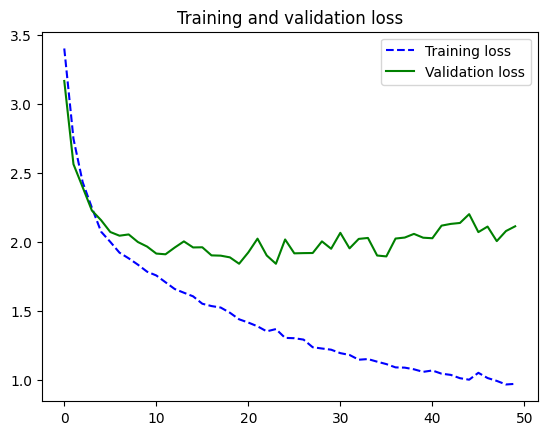

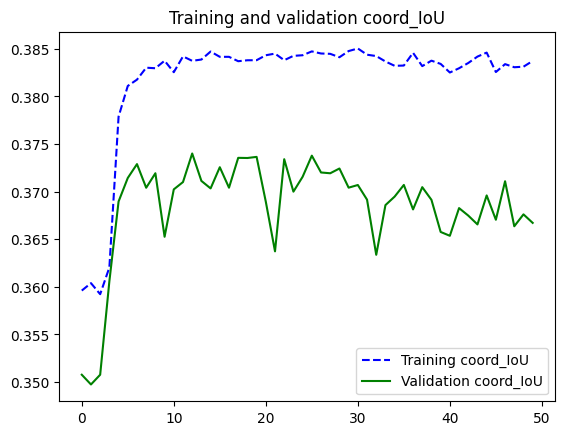

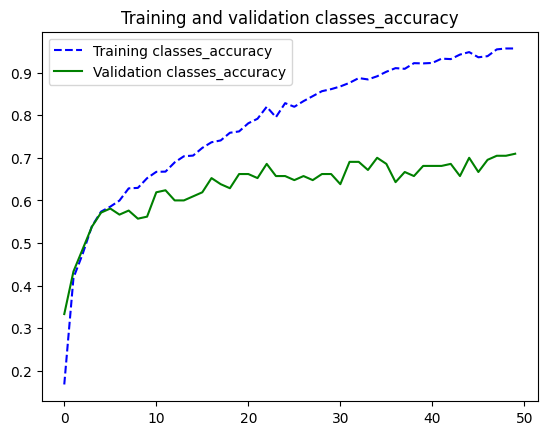

8/8 [==============================] - 0s 20ms/step


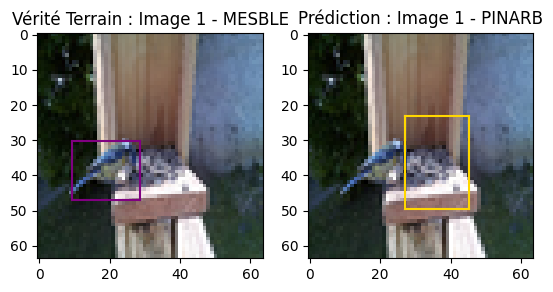

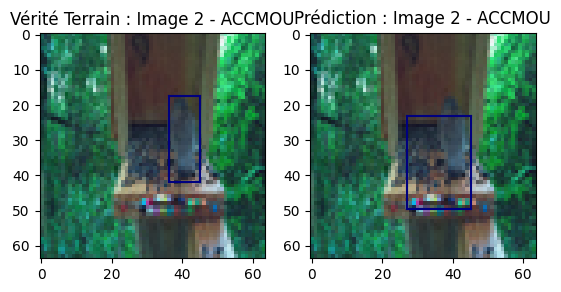

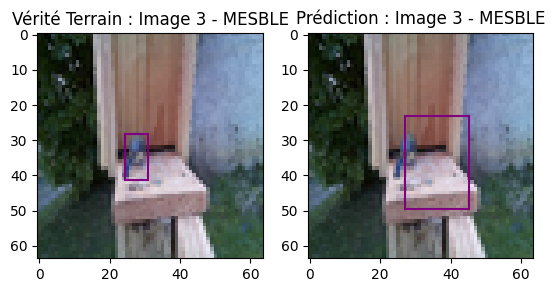

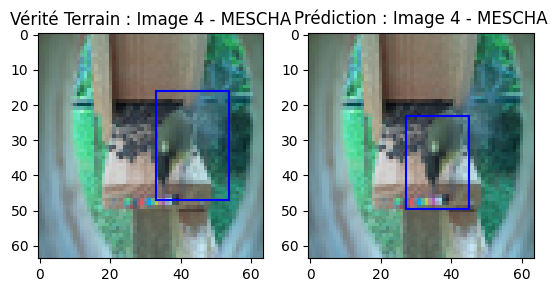

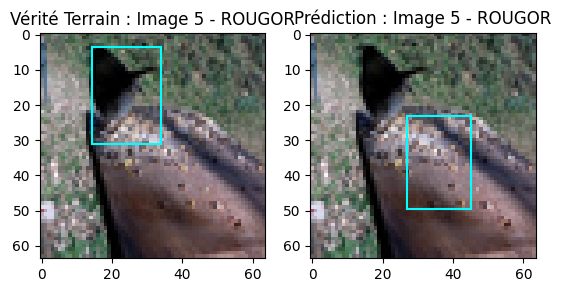

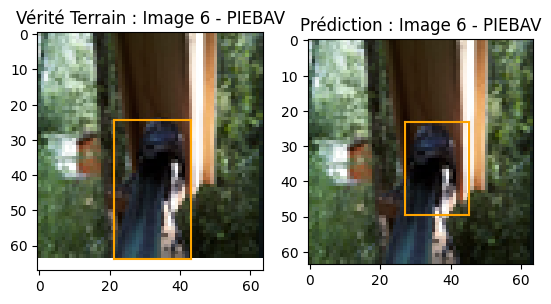

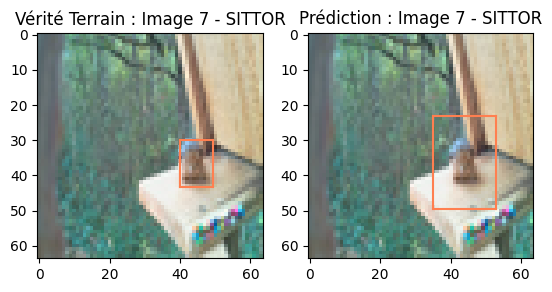

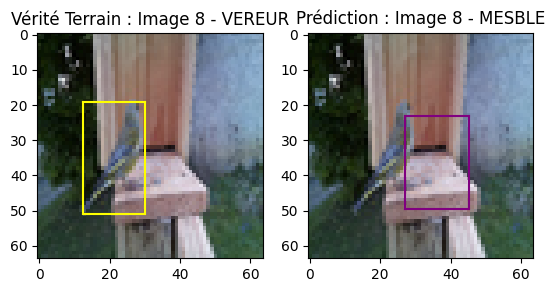

In [82]:
# Analyse des résultats : courbes d'évolution de la fonction de perte, et de l'IoU des boîtes englobantes ainsi que de la précision des classes prédites
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_IoU')
plot_training_analysis(history, metric='classes_accuracy')

# Prédiction des données de test
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_test)
y_pred = np.zeros(y_test.shape)
for i in range(y_pred.shape[0]):
  y_pred[i, 0] = y_pred_presence[i]
  y_pred[i, 1:5] = y_pred_coords[i]
  y_pred[i, 5:] = y_pred_classes[i]

# Affichage des résultats sur plusieurs images
print_data_localisation(x_test, y_test, y_pred = y_pred, id=1, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=4, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=5, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=6, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=8, image_size=IMAGE_SIZE)

In [83]:
class_res, accuracy = global_accuracy(y_test, y_pred)

print(f"La précision globale est de {accuracy:.1f}%")

print()
print("------------------------------------------")
print("| Classe | Précision | Rappel | F1-score |")
print("------------------------------------------")
for i in range(num_classes):
  print(f"| {class_labels[i]:7s}|   {class_res[i]['Precision']:.2f}    |  {class_res[i]['Rappel']:.2f}  |   {class_res[i]['F-score']:.2f}   |")
  print("------------------------------------------")


La précision globale est de 11.2%

------------------------------------------
| Classe | Précision | Rappel | F1-score |
------------------------------------------
| MESCHA |   0.07    |  0.05  |   0.05   |
------------------------------------------
| VEREUR |   0.12    |  0.14  |   0.13   |
------------------------------------------
| ECUROU |   0.32    |  0.32  |   0.32   |
------------------------------------------
| PIEBAV |   0.05    |  0.05  |   0.05   |
------------------------------------------
| SITTOR |   0.23    |  0.14  |   0.17   |
------------------------------------------
| PINARB |   0.16    |  0.18  |   0.17   |
------------------------------------------
| MESNOI |   0.08    |  0.07  |   0.07   |
------------------------------------------
| MESNON |   0.06    |  0.14  |   0.09   |
------------------------------------------
| MESBLE |   0.00    |  0.00  |   0.00   |
------------------------------------------
| ROUGOR |   0.05    |  0.05  |   0.05   |
-------------------

En pratique, il est délicat de trouver une bonne combinaison des fonctions de perte tel que vous l'avez fait sur les cellules précédentes. L'entropie croisée et l'erreur quadratique moyenne donnent des valeurs trop différentes pour être combinables efficacement.

Une variante, peut-être plus simple à faire fonctionner, est d'utiliser uniquement l'erreur quadratique moyenne comme perte pour toutes les sorties. C'est cette variante qui est implémentée dans l'algorithme YOLO, dont nous implémenterons une version simplifiée dans le prochain TP.
Testez cette solution ci-dessous. Comme sur l'exercice précédent, n'hésitez pas à faire varier le poids des différents éléments de la fonction de coût.

In [84]:
batch_size=16
model = create_model_localisation()
opt = Adam(learning_rate=3e-4)  

loss = ['mse', 'mse', 'mse']
metrics =[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1, 1, 1]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )
history = model.fit(x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:]],
              epochs=50,
              batch_size=batch_size,            
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:]]))


Epoch 1/50
118/118 [==============================] - 4s 12ms/step - loss: 1.1489 - p_loss: 0.0961 - coord_loss: 0.9701 - classes_loss: 0.0827 - p_accuracy: 0.9008 - coord_IoU: 0.3625 - classes_accuracy: 0.0992 - val_loss: 1.0180 - val_p_loss: 0.0121 - val_coord_loss: 0.9239 - val_classes_loss: 0.0820 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.3648 - val_classes_accuracy: 0.1524
Epoch 2/50
118/118 [==============================] - 1s 9ms/step - loss: 0.9535 - p_loss: 0.0091 - coord_loss: 0.8644 - classes_loss: 0.0800 - p_accuracy: 0.9995 - coord_IoU: 0.3796 - classes_accuracy: 0.2280 - val_loss: 1.0017 - val_p_loss: 0.0090 - val_coord_loss: 0.9164 - val_classes_loss: 0.0763 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.3711 - val_classes_accuracy: 0.2238
Epoch 3/50
118/118 [==============================] - 1s 9ms/step - loss: 0.8954 - p_loss: 0.0074 - coord_loss: 0.8137 - classes_loss: 0.0743 - p_accuracy: 1.0000 - coord_IoU: 0.4011 - classes_accuracy: 0.3043 - val_loss: 0.8930 - val_

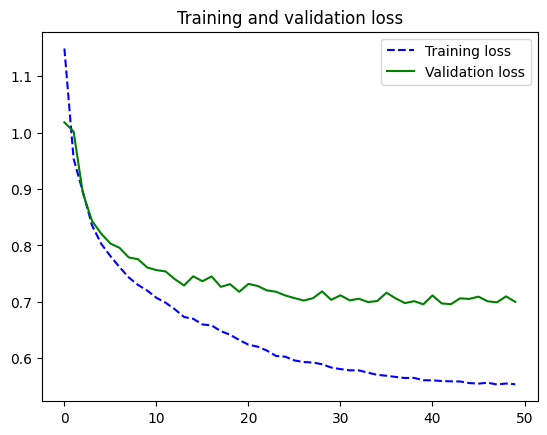

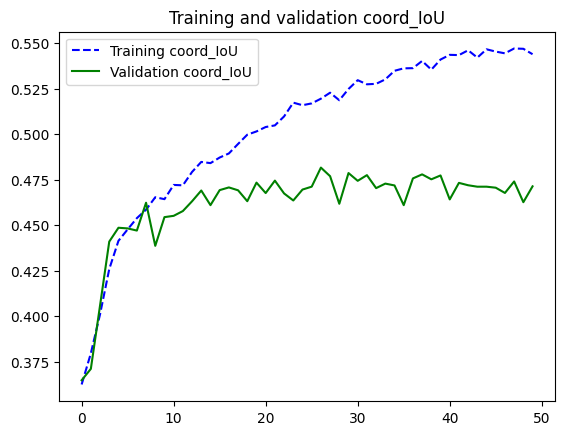

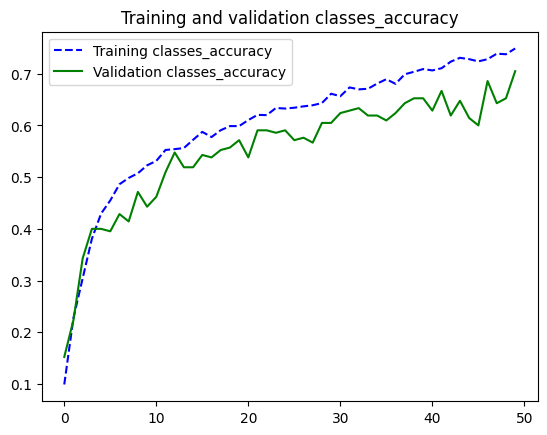

8/8 [==============================] - 0s 3ms/step


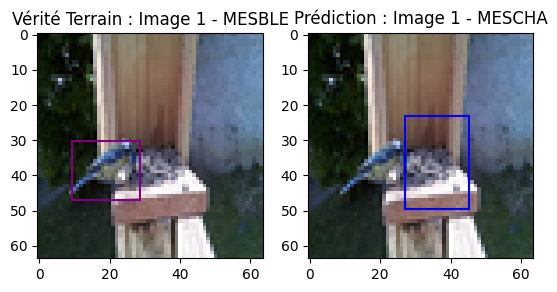

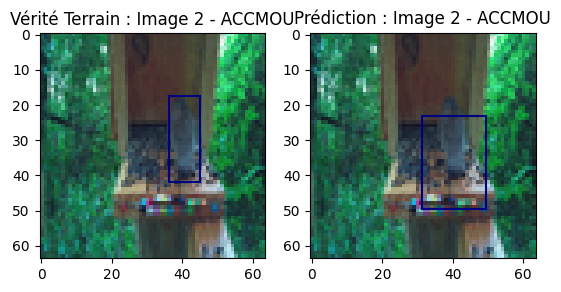

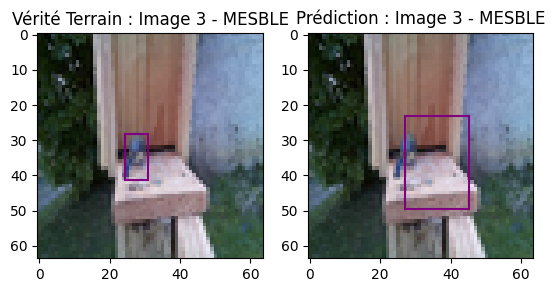

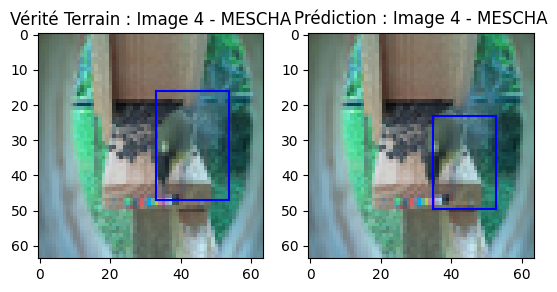

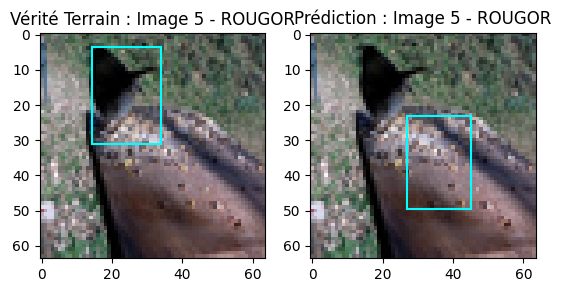

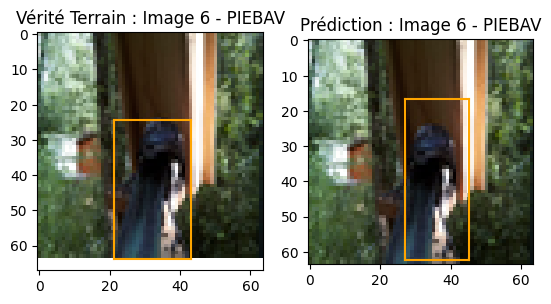

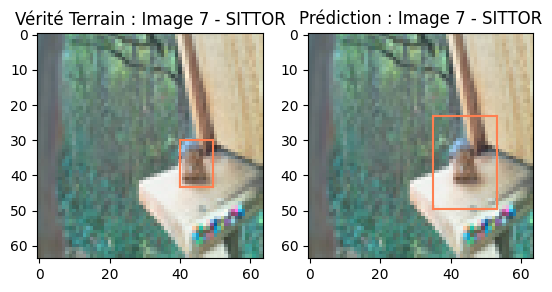

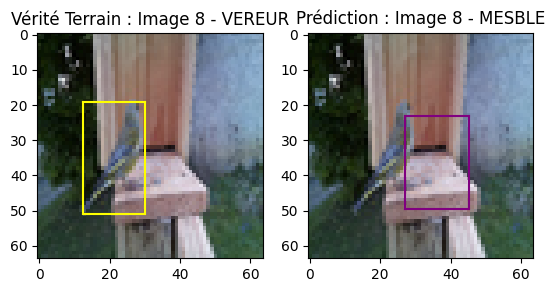

La précision globale est de 32.6%

------------------------------------------
| Classe | Précision | Rappel | F1-score |
------------------------------------------
| MESCHA |   0.29    |  0.18  |   0.22   |
------------------------------------------
| VEREUR |   0.12    |  0.14  |   0.13   |
------------------------------------------
| ECUROU |   0.82    |  0.82  |   0.82   |
------------------------------------------
| PIEBAV |   0.78    |  0.82  |   0.80   |
------------------------------------------
| SITTOR |   0.19    |  0.18  |   0.19   |
------------------------------------------
| PINARB |   0.44    |  0.55  |   0.49   |
------------------------------------------
| MESNOI |   0.06    |  0.07  |   0.06   |
------------------------------------------
| MESNON |   0.11    |  0.09  |   0.10   |
------------------------------------------
| MESBLE |   0.00    |  0.00  |   0.00   |
------------------------------------------
| ROUGOR |   0.17    |  0.19  |   0.18   |
-------------------

In [85]:
# Analyse des résultats : courbes d'évolution de la fonction de perte, et de l'IoU des boîtes englobantes ainsi que de la précision des classes prédites
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_IoU')
plot_training_analysis(history, metric='classes_accuracy')

# Prédiction des données de test
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_test)
y_pred = np.zeros(y_test.shape)
for i in range(y_pred.shape[0]):
  y_pred[i, 0] = y_pred_presence[i]
  y_pred[i, 1:5] = y_pred_coords[i]
  y_pred[i, 5:] = y_pred_classes[i]

# Affichage des résultats sur plusieurs images
print_data_localisation(x_test, y_test, y_pred = y_pred, id=1, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=4, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=5, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=6, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=8, image_size=IMAGE_SIZE)


class_res, accuracy = global_accuracy(y_test, y_pred, iou_thres=0.4)

print(f"La précision globale est de {accuracy:.1f}%")

print()
print("------------------------------------------")
print("| Classe | Précision | Rappel | F1-score |")
print("------------------------------------------")
for i in range(num_classes):
  print(f"| {class_labels[i]:7s}|   {class_res[i]['Precision']:.2f}    |  {class_res[i]['Rappel']:.2f}  |   {class_res[i]['F-score']:.2f}   |")
  print("------------------------------------------")


Compte-tenu de la taille réduite de la base de données, les résultats ne sont pas mal du tout ! On observe quelques confusions entre certaines classes mais les prédictions sont souvent intéressantes.

Il devrait cependant subsister un fort surapprentissage à ce stade. Comme nous l'avons vu dans de précédents TPs, vous avez plusieurs possibilités qui s'offrent à vous pour le corriger : 

*   Augmentation de la base de données. Vous pouvez pour cela vous appuyer sur l'exemple fourni en TP précédent, avec une classe *Sequence* et l'utilisation de la librairie *Albumentation*. Je vous fournis une Sequence qui fonctionne ci-dessous.
*   Utilisation de *transfer learning* : partant d'un réseau entraîné sur ImageNet (qui contient de nombreuses classes d'animaux), vous bénéficieriez de filtres très généraux qui aiderait à limiter le surapprentissage. 



# Code fourni pour vous aider à mettre en place l'augmentation de données

Il y a des problèmes avec les versions d'openCV et d'Albumentation, voici comment les résoudre :

In [86]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.1.2.30
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

Found existing installation: opencv-python-headless 4.7.0.72
Uninstalling opencv-python-headless-4.7.0.72:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/cv2/*
    /usr/local/lib/python3.9/dist-packages/opencv_python_headless-4.7.0.72.dist-info/*
    /usr/local/lib/python3.9/dist-packages/opencv_python_headless.libs/libavcodec-16a334ab.so.59.37.100
    /usr/local/lib/python3.9/dist-packages/opencv_python_headless.libs/libavformat-e0b1067c.so.59.27.100
    /usr/local/lib/python3.9/dist-packages/opencv_python_headless.libs/libavutil-82c407cb.so.57.28.100
    /usr/local/lib/python3.9/dist-packages/opencv_python_headless.libs/libcrypto-47343492.so.1.1
    /usr/local/lib/python3.9/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.9/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.9/dist-packages/opencv_python_headless.libs/libpng16-57e5e0a0.so.16.37.0
    /usr/local/lib/python3.9/

Définition des augmentations (uniquement colorimétriques ici)

In [87]:
import cv2 as cv
from albumentations import (Compose, RandomBrightnessContrast, HorizontalFlip)
import albumentations as A

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

Une sequence qui permet d'implanter l'augmentation de données :

In [88]:
from tensorflow.keras.utils import Sequence

class MangeoireSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, y_set, batch_size,augmentations):
        self.x, self.y = x_set, y_set
        self.classes = ['MESCHA', 'VEREUR', 'ECUROU', 'PIEBAV', 'SITTOR', 'PINARB', 'MESNOI', 'MESNON', 'MESBLE', 'ROUGOR', 'ACCMOU']
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(x_set.shape[0]) 
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    # Il y a des problèmes d'arrondi dans les conversions de boîtes englobantes 
    # internes à la librairie Albumentations
    # Pour les contourner, si les boîtes sont trop proches des bords, on les érode un peu
    def erode_bounding_box(self, box):
        epsilon = 0.01
        
        xmin = max(box[0] - box[2]/2, epsilon)
        ymin = max(box[1] - box[3]/2, epsilon)
        xmax = min(box[0] + box[2]/2, 1-epsilon)
        ymax = min(box[1] + box[3]/2, 1-epsilon)
        
        cx = xmin + (xmax - xmin)/2
        cy = ymin + (ymax - ymin)/2
        width = xmax - xmin
        height = ymax - ymin
        
        return np.array([cx, cy, width, height])
    
    # Application de l'augmentation de données à chaque image du batch et aux
    # boîtes englobantes associées
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros((bx.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        batch_y = by
        
        # Pour chaque image du batch
        for i in range(len(bx)):
            bboxes = []
            box = by[i,1:5]
            # Dénormalisation des coordonnées de boites englobantes
            box[0] = (box[0]*y_std[1] + y_mean[1])
            box[1] = (box[1]*y_std[2] + y_mean[2])
            box[2] = (box[2]*y_std[3] + y_mean[3])
            box[3] = (box[3]*y_std[4] + y_mean[4])
            box = self.erode_bounding_box(box)
            bboxes.append(box)
            
            class_labels = []
            class_id = np.argmax(by[i, 5:])
            class_labels.append(self.classes[class_id])

            img = bx[i].astype('float32')

            # Application de l'augmentation à l'image et aux masques
            transformed = self.augment(image=img.astype('float32'), bboxes=bboxes, class_labels=class_labels)
            batch_x[i] = transformed['image']
            batch_y_transformed = transformed['bboxes']
                
            # Renormalisation des coordonnées de boîte englobante transformée
            batch_y[i, 1] = (batch_y_transformed[0][0] - y_mean[1])/y_std[1]
            batch_y[i, 2] = (batch_y_transformed[0][1] - y_mean[2])/y_std[2]
            batch_y[i, 3] = (batch_y_transformed[0][2] - y_mean[3])/y_std[3]
            batch_y[i, 4] = (batch_y_transformed[0][3] - y_mean[4])/y_std[4]

        return batch_x, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    def __getitem__(self, idx):
        batch_x = self.x[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_x, batch_y = self.apply_augmentation(batch_x, batch_y)
        
        batch_y = np.array(batch_y)
        return np.array(batch_x), [batch_y[:,0], batch_y[:,1:5], batch_y[:,5:]]

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)
        


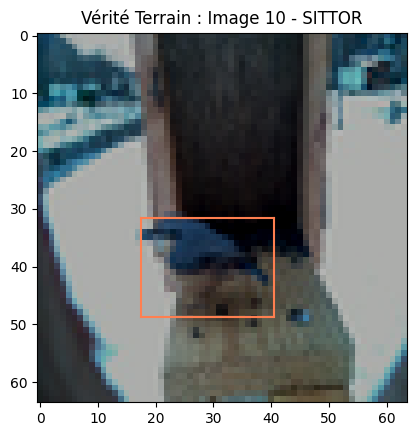

In [91]:
# Instanciation d'une Sequence
train_gen = MangeoireSequence(x_train, y_train, 16, augmentations=AUGMENTATIONS_TRAIN)

# Pour tester la séquence, nous sélectionnons les éléments du premier batch et les affichons
batch_x, batch_y = train_gen.__getitem__(0)

y_batch = np.zeros((batch_y[0].shape[0],1+4+num_classes))

for i in range(batch_y[0].shape[0]):
  y_batch[i, 0] = batch_y[0][i]
  y_batch[i, 1:5] = batch_y[1][i]
  y_batch[i, 5:] = batch_y[2][i]

print_data_localisation(batch_x, y_batch, image_size=IMAGE_SIZE)

In [94]:
batch_size=16
model = create_model_localisation()
opt = Adam(learning_rate=3e-4)  

loss = ['mse', 'mse', 'mse']
metrics =[ ['accuracy'], [iou()], ['accuracy']]
loss_weights = [1, 1, 1]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )
history = model.fit(x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:]],
              epochs=50,
              batch_size=batch_size,            
              validation_data=(x_val, [y_val[:,0], y_val[:,1:5], y_val[:,5:]]))


Epoch 1/50
118/118 [==============================] - 5s 12ms/step - loss: 1.0837 - p_loss: 0.0418 - coord_loss: 0.9594 - classes_loss: 0.0825 - p_accuracy: 0.9597 - coord_IoU: 0.3679 - classes_accuracy: 0.1135 - val_loss: 1.0281 - val_p_loss: 0.0142 - val_coord_loss: 0.9321 - val_classes_loss: 0.0818 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.3903 - val_classes_accuracy: 0.1524
Epoch 2/50
118/118 [==============================] - 1s 9ms/step - loss: 0.9423 - p_loss: 0.0085 - coord_loss: 0.8546 - classes_loss: 0.0792 - p_accuracy: 0.9989 - coord_IoU: 0.4082 - classes_accuracy: 0.2275 - val_loss: 0.9756 - val_p_loss: 0.0098 - val_coord_loss: 0.8896 - val_classes_loss: 0.0762 - val_p_accuracy: 1.0000 - val_coord_IoU: 0.3979 - val_classes_accuracy: 0.3095
Epoch 3/50
118/118 [==============================] - 2s 13ms/step - loss: 0.8961 - p_loss: 0.0068 - coord_loss: 0.8162 - classes_loss: 0.0731 - p_accuracy: 1.0000 - coord_IoU: 0.4260 - classes_accuracy: 0.3399 - val_loss: 0.9090 - val

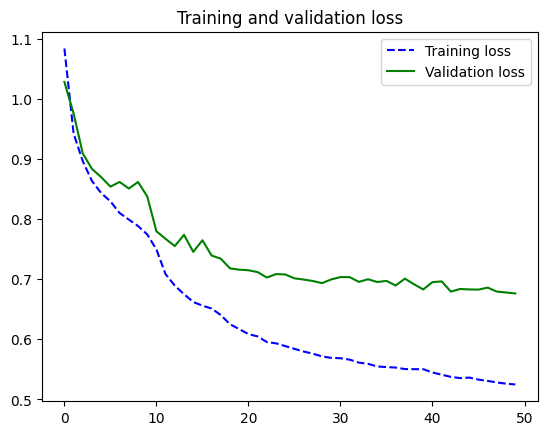

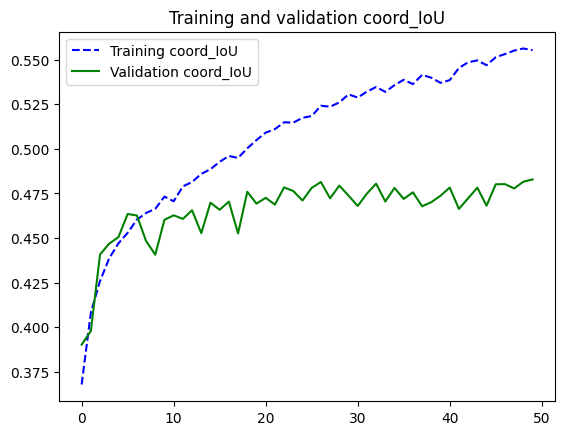

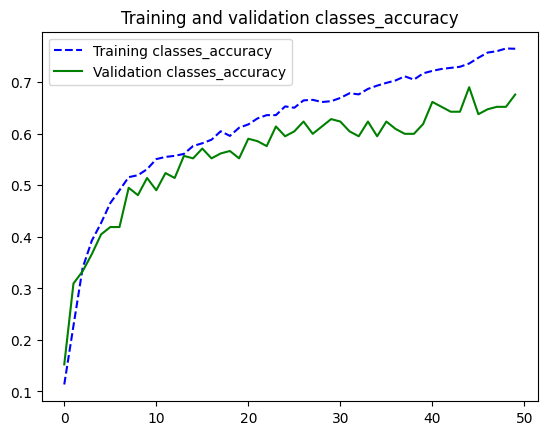

8/8 [==============================] - 0s 3ms/step


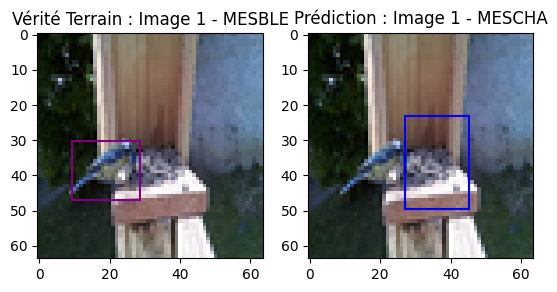

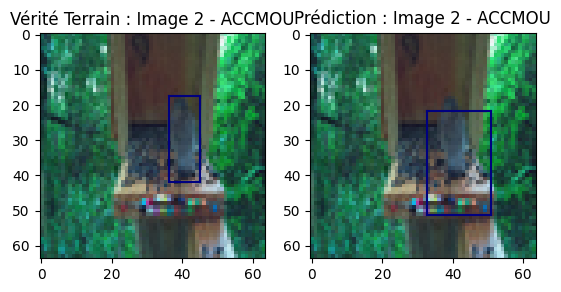

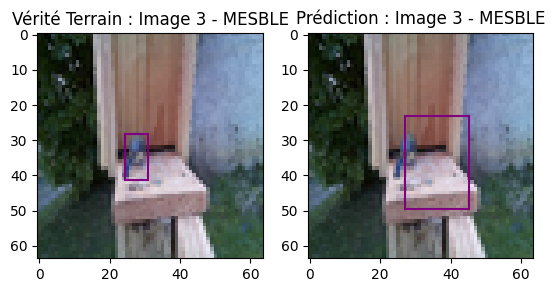

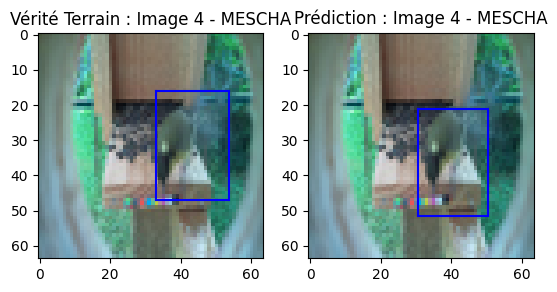

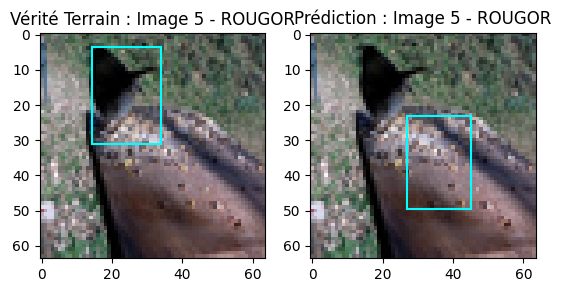

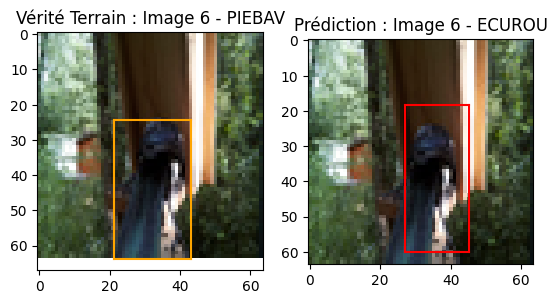

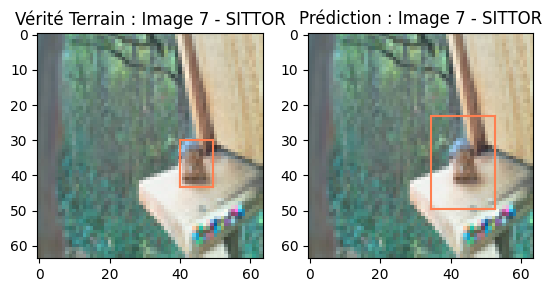

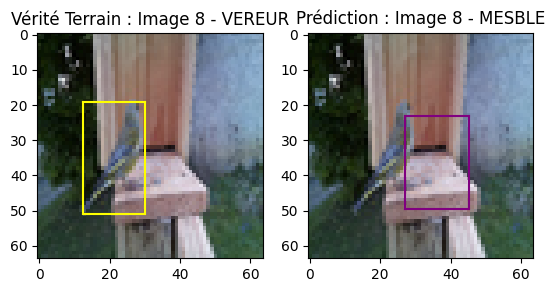

La précision globale est de 35.2%

------------------------------------------
| Classe | Précision | Rappel | F1-score |
------------------------------------------
| MESCHA |   0.47    |  0.32  |   0.38   |
------------------------------------------
| VEREUR |   0.17    |  0.18  |   0.17   |
------------------------------------------
| ECUROU |   0.78    |  0.82  |   0.80   |
------------------------------------------
| PIEBAV |   0.77    |  0.77  |   0.77   |
------------------------------------------
| SITTOR |   0.25    |  0.23  |   0.24   |
------------------------------------------
| PINARB |   0.58    |  0.50  |   0.54   |
------------------------------------------
| MESNOI |   0.04    |  0.07  |   0.05   |
------------------------------------------
| MESNON |   0.17    |  0.14  |   0.15   |
------------------------------------------
| MESBLE |   0.05    |  0.05  |   0.05   |
------------------------------------------
| ROUGOR |   0.22    |  0.24  |   0.23   |
-------------------

In [95]:
# Analyse des résultats : courbes d'évolution de la fonction de perte, et de l'IoU des boîtes englobantes ainsi que de la précision des classes prédites
plot_training_analysis(history, metric='loss')
plot_training_analysis(history, metric='coord_IoU')
plot_training_analysis(history, metric='classes_accuracy')

# Prédiction des données de test
y_pred_presence, y_pred_coords, y_pred_classes = model.predict(x_test)
y_pred = np.zeros(y_test.shape)
for i in range(y_pred.shape[0]):
  y_pred[i, 0] = y_pred_presence[i]
  y_pred[i, 1:5] = y_pred_coords[i]
  y_pred[i, 5:] = y_pred_classes[i]

# Affichage des résultats sur plusieurs images
print_data_localisation(x_test, y_test, y_pred = y_pred, id=1, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=2, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=3, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=4, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=5, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=6, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=7, image_size=IMAGE_SIZE)
print_data_localisation(x_test, y_test, y_pred = y_pred, id=8, image_size=IMAGE_SIZE)


class_res, accuracy = global_accuracy(y_test, y_pred, iou_thres=0.4)

print(f"La précision globale est de {accuracy:.1f}%")

print()
print("------------------------------------------")
print("| Classe | Précision | Rappel | F1-score |")
print("------------------------------------------")
for i in range(num_classes):
  print(f"| {class_labels[i]:7s}|   {class_res[i]['Precision']:.2f}    |  {class_res[i]['Rappel']:.2f}  |   {class_res[i]['F-score']:.2f}   |")
  print("------------------------------------------")
